<a href="https://colab.research.google.com/github/ThatManRong/RL_Thesis/blob/Single-Asset/HeapMap_Jan1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generate Sample Paths

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl

In [2]:
def SimPaths(S0, kappa, theta, sigma, T, Ndt, Nsims):
    
    # time grid
    t = np.linspace(0, T, Ndt+1)
    dt = t[1]-t[0]
    sqrt_dt = np.sqrt(dt)

    # effective vol for large time steps
    #   sigma_eff = sigma *sqrt( (1-exp(-2*kappa*dt)) / (2*kappa) )
    #             ~ sigma *sqrt(  ( 1 - (1-2*kappa*dt + ..) ) /(2 *kappa) )
    #             ~ sigma *sqrt(  dt )
    sigma_eff = sigma * np.sqrt( (1-np.exp(-2*kappa*dt)) / (2*kappa))

    # store the sample paths
    X = np.zeros((Nsims, Ndt+1))
    Y = np.zeros((Nsims, Ndt+1))
    Z = np.zeros((Nsims, Ndt+1))

    X[:,0] = S0[0]
    Y[:,0] = S0[1]
    Z[:,0] = S0[2]


    for i in range(Ndt):

#         # Euler discretization of the SDE
#         #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
#         dW_x = sqrt_dt * np.random.randn(Nsims)
#         X[:,i+1] = X[:,i]  + kappa[0] * (theta[0] - X[:,i]) * dt + sigma[0] * dW_x

#         # Euler discretization of the SDE
#         #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
#         dW_y = sqrt_dt * np.random.randn(Nsims)
#         Y[:,i+1] = Y[:,i] + kappa[1] * (theta[1] - Y[:,i]) * dt + sigma[1] * dW_y

        # Exact solution to the SDE
        #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
        N_x =  np.random.randn(Nsims)
        X[:,i+1] = theta[0] + (X[:,i]-theta[0])*np.exp(-kappa[0]*dt) + sigma_eff[0] * N_x
        
        # Euler discretization of the SDE
        #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
        N_y = np.random.randn(Nsims)
        Y[:,i+1] = theta[1] + (Y[:,i]-theta[1])*np.exp(-kappa[1]*dt) + sigma_eff[1] * N_y

        # update Z according to no-arbitrage
        Z[:,i+1] = 1.0/(X[:,i+1]*Y[:,i+1])
        
    return t, X, Y, Z

In [124]:
# model paramteres on hourly time scales
kappa = np.array([2, 2])
theta = np.array([1, 1.1])
sigma = np.array([1, 1])*1e-2

# initial values of the FX rates
X0 = 1.000
Y0 = 1.1 #1.0995
Z0 = 1.0/(X0*Y0)

T = 1 # in minutes
Ndt = 5 # in miliseconds

Nsims = 2000 # number of sims

t, X, Y, Z = SimPaths([X0, Y0, Z0], kappa, theta, sigma, T, Ndt, Nsims)

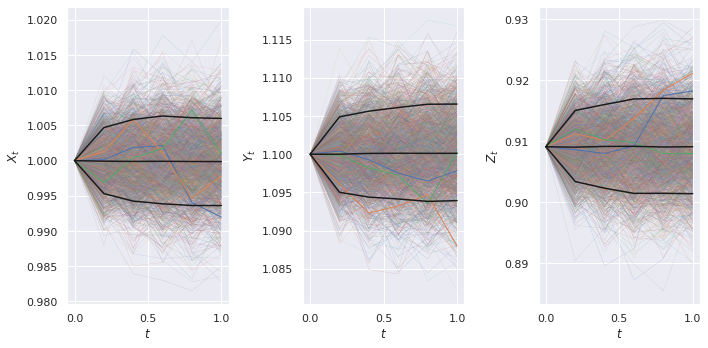

In [125]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(t, X.T, linewidth=0.1)
plt.plot(t, X[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(X,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$X_t$')

plt.subplot(1,3,2)
plt.plot(t, Y.T, linewidth=0.1)
plt.plot(t, Y[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Y,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Y_t$')

plt.subplot(1,3,3)
plt.plot(t, Z.T, linewidth=0.1)
plt.plot(t, Z[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Z,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Z_t$')

fig.tight_layout()

plt.show()

In [126]:
import pandas as pd
data = {'Time': t, 
        'X': X[0],
        'Y' : Y[0],
        'Z': Z[0]}
  
# Convert the dictionary into DataFrame 
data = pd.DataFrame(data) 
print(data)

   Time         X         Y         Z
0   0.0  1.000000  1.100000  0.909091
1   0.2  1.000147  1.100424  0.908608
2   0.4  1.001872  1.099271  0.907994
3   0.6  1.002125  1.097531  0.909204
4   0.8  0.994036  1.096482  0.917479
5   1.0  0.991978  1.097850  0.918237


In [ ]:
# train_test_split = 0.5
# train = data[:int(train_test_split*len(data))]
# test = data[int(train_test_split*len(data)):]

#State: 
>$S_t=(X_t, P_t) $

where X is inventory and P is price

#Action: 
>$a_t = \{Buy, Sell, Hold\} $

#State Evolution
>$X_{t+1}= X_t + a_t $

>$P_{t+1}= f(P_t) + \epsilon $

In [38]:
class Environment2:
    
    def __init__(self, data, history_t=5):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0

        # act = 0: stay, 
        #1: buy, 
        #2: sell
        max_holding = 5
        if act == 1:
            if len(self.positions)>=max_holding:
              reward = -1
            else:
              self.positions.append(self.data.iloc[self.t, :]['X'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['X'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        if len(self.positions)>=max_holding:
          reward = -1
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['X'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['X'] - 1.0000)
        if (self.t==len(self.data)-1):
            self.done=True
            #self.positions = []
            #act = 2   #Force selling at end of period


        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        #actual_action = act
        return [self.position_value] + self.history, reward, self.done, self.positions # obs, reward, done

In [ ]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0

        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            if len(self.positions)>=20:
              reward = -1
            else:
              self.positions.append(self.data.iloc[self.t, :]['X'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['X'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        if len(self.positions)>=10:
          reward = -1
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['X'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['X'] - 1.0000)
        if (self.t==len(self.data)-1):
            self.done=True
            #self.positions = []
            #act = 2   #Force selling at end of period


        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        actual_action = act
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [13]:
class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)

In [15]:
hidden_size=20
input_size=11
output_size=3
USE_CUDA = False
LR = 0.001

In [16]:
Q = Q_Network(input_size, hidden_size, output_size)

In [17]:
Q_ast = copy.deepcopy(Q)


In [18]:
if USE_CUDA:
    Q = Q.cuda()
    print("using Cuda")
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

In [20]:
#epoch_num = 20
memory_size = 20000
batch_size = 200
gamma = 0.99

memory = []
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.01
start_reduce_epsilon = 200
train_freq = 10
update_q_freq = 20
gamma = 0.99
show_log_freq = 100


In [24]:
# epoch_data = {'Time': t, 
#         'X': X[1]}
# epoch_data = pd.DataFrame(epoch_data) 
# env = Environment2(epoch_data)
# step_max = len(env.data)-1

In [25]:
master_reward = []
#start = time.time()
for epoch in range(len(X[:5000])):
    epoch_data = {'Time': t, 
        'X': X[epoch]}
    print("Percentage done: ", epoch/5000)
    epoch_data = pd.DataFrame(epoch_data) 
    env = Environment2(epoch_data)
    step_max = len(env.data)-1
    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0
    iterations = []
    log_rewards = []
    log_losses = []
    iteration = 1
    trading_history = []
    while not done and step < step_max:
        if done:
          trading_history = []  #For pair trading, make sure the stock
        # select action
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:  #Epsilon greedy Exploration
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()
        # if step == step_max - 1:
        #   pact = 2
        # act
        obs, reward, done = env.step(pact)
        # if done is True:
        #     print("action is: ", actual_action, "  Reward is: ", reward, "  Done? ", done)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        #memory.append((pobs, actual_action, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        master_reward.append(total_rewards)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            
            iterations.append(iteration)
            iteration += 1
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_rewards.append(log_reward)
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_losses.append(log_loss)
            #elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss])))
            #start = time.time()
            
#return Q, total_losses, total_rewards

Percentage done:  0.0
Percentage done:  0.0002
Percentage done:  0.0004
Percentage done:  0.0006
Percentage done:  0.0008
Percentage done:  0.001
Percentage done:  0.0012
Percentage done:  0.0014
Percentage done:  0.0016
Percentage done:  0.0018
Percentage done:  0.002
Percentage done:  0.0022
Percentage done:  0.0024
Percentage done:  0.0026
Percentage done:  0.0028
Percentage done:  0.003
Percentage done:  0.0032
Percentage done:  0.0034
Percentage done:  0.0036
Percentage done:  0.0038
Percentage done:  0.004
Percentage done:  0.0042
Percentage done:  0.0044
Percentage done:  0.0046
Percentage done:  0.0048
Percentage done:  0.005
Percentage done:  0.0052
Percentage done:  0.0054
Percentage done:  0.0056
Percentage done:  0.0058
Percentage done:  0.006
Percentage done:  0.0062
Percentage done:  0.0064
Percentage done:  0.0066
Percentage done:  0.0068
Percentage done:  0.007
Percentage done:  0.0072
Percentage done:  0.0074
Percentage done:  0.0076
Percentage done:  0.0078
Percentage

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Streaming output truncated to the last 5000 lines.
1700	0.00999999999999912	64952	3033.15	55131.91016415361
1700	0.00999999999999912	64953	3033.16	55131.91016415361
1700	0.00999999999999912	64954	3033.17	55131.91016415361
1700	0.00999999999999912	64955	3033.18	55131.91016415361
1700	0.00999999999999912	64956	3033.19	55131.91016415361
1700	0.00999999999999912	64957	3033.21	55131.91016415361
1700	0.00999999999999912	64958	3033.23	55131.91016415361
1700	0.00999999999999912	64959	3033.25	55131.91016415361
1700	0.00999999999999912	64960	3033.27	55131.91016415361
1700	0.00999999999999912	64961	3033.29	55132.346709849575
1700	0.00999999999999912	64962	3033.31	55132.78325554553
1700	0.00999999999999912	64963	3033.33	55133.219801241496
1700	0.00999999999999912	64964	3033.35	55133.65634693745
1700	0.00999999999999912	64965	3033.37	55134.092892633416
1700	0.00999999999999912	64966	3033.4	55134.52943832937
1700	0.00999999999999912	64967	3033.43	55134.96598402534
1700	0.00999999999999912	64968	3033

In [ ]:
print(len(total_rewards[:-600]))

In [ ]:
t_in_ms = [i for i in range(100)]
fig = plt.figure(figsize=(30,5))
plt.subplot(1,5,1)
plt.plot(t_in_ms, total_rewards[600:700], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,2)
plt.plot(t_in_ms, total_rewards[9600:9700], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,3)
plt.plot(t_in_ms, total_rewards[19200:19300], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
# plt.subplot(1,5,4)
# plt.plot(t_in_ms, total_rewards[30000:30100], linewidth=1)
# plt.xlabel('$t$')
# plt.ylabel('$Rewards$')
# plt.subplot(1,5,5)
# plt.plot(t_in_ms, total_rewards[40000:40100], linewidth=1)
# plt.xlabel('$t$')
# plt.ylabel('$Rewards$')

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(iterations, log_rewards, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Rewards')
plt.subplot(1,2,2)
plt.plot(iterations, log_losses, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Losses')

In [ ]:
print(len(log_rewards))
incremental_reward = []
for i in range(len(log_rewards)):
  if i>=1:
    incremental_reward.append((log_rewards[i]-log_rewards[i-1])/memory_size)


In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(iterations[:-1], incremental_reward, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('incremental_reward')

In [39]:
test_data = {'Time': t, 
        'X': X[4500]}
test_data = pd.DataFrame(test_data) 
test_env = Environment2(test_data)

In [45]:
#test_env = Environment1(X[100])
pobs = test_env.reset()
test_acts = []
test_rewards = []
inventory = []
for _ in range(len(test_env.data)-1):
    
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    
    #print(pact.numpy())        
    obs, reward, done, epoch_inventory = test_env.step(pact.numpy())
    inventory.append(len(epoch_inventory))
    test_acts.append(pact.numpy())
    test_rewards.append(reward)

    pobs = obs
        
test_profits = test_env.profits

In [47]:
print(len(inventory))

50


In [35]:
buy_point = []
buy_time = []
sell_point = []
sell_time = []
for i in range(len(test_acts)):
  if test_acts[i] == 1:
    buy_point.append(X[4500][i])
    buy_time.append(i/len(test_acts))
  if test_acts[i] == 2:
    sell_point.append(X[4500][i])
    sell_time.append(i/len(test_acts))

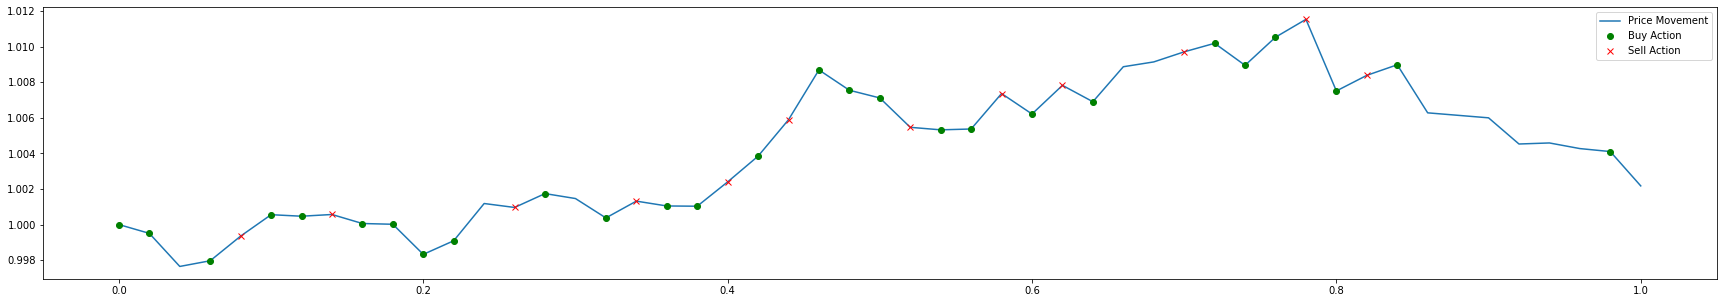

In [36]:
fig = plt.figure(figsize=(30,5))
plt.plot(t,X[4500])
plt.plot(buy_time, buy_point, 'o', color='green')
plt.plot(sell_time, sell_point, 'x', color='red');
plt.legend(["Price Movement","Buy Action","Sell Action"])
#print(mark)
plt.show()

In [ ]:
t_in_ms = [i for i in range(len(test_rewards))]
plt.plot(t_in_ms, test_rewards, linewidth=1)

In [37]:
print(test_profits)

0.019625170631076827


In [ ]:
#Try all sample path
samplepath_number = []
test_profits = []
actions = []
all_inventory = []
for i in range(5001,len(X)):
  epoch_action = []
  inventory = []
  test_data = {'Time': t, 
        'X': X[i]}
  # Convert the dictionary into DataFrame 
  test_data = pd.DataFrame(test_data) 
  test_env = Environment2(test_data)
  pobs = test_env.reset()
  test_acts = []
  test_rewards = []
  print("Percentage done: ", i*100/len(X))
  for i in range(len(test_env.data)-1):
      #inventory.append(0)
      pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
      pact = np.argmax(pact.data)
      test_acts.append(pact.item())
      #print(pact.numpy())        
      # if pact.numpy() == 1:
      #   if i > 0:
      #     inventory[i] = inventory[i-1]+1

      obs, reward, done, epoch_inventory = test_env.step(pact.numpy())
      inventory.append(len(epoch_inventory))
      epoch_action.append(pact.numpy())
      test_rewards.append(reward)

      pobs = obs
  epoch_action[49] = 2
  actions.append(epoch_action)
  all_inventory.append(inventory)        
  test_profits.append(test_env.profits)
  samplepath_number.append(i+1)




In [56]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

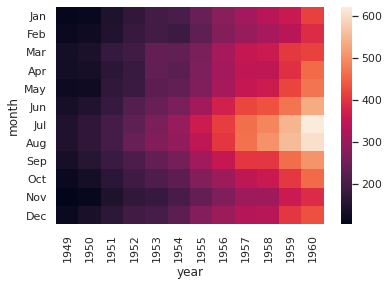

In [76]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)

In [75]:
print(flights)

     year month  passengers
0    1949   Jan         112
1    1949   Feb         118
2    1949   Mar         132
3    1949   Apr         129
4    1949   May         121
..    ...   ...         ...
139  1960   Aug         606
140  1960   Sep         508
141  1960   Oct         461
142  1960   Nov         390
143  1960   Dec         432

[144 rows x 3 columns]


In [115]:
#Begin of the day: t = 5
time_spot = 5
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  price_spot.append(X[i+5001][time_spot])
  inventory_spot.append(all_inventory[i][time_spot])
  action_spot.append(actions[i][time_spot])
price_quartile = []
for i in range(len(price_spot)):
  if price_spot[i] <= np.quantile(price_spot,0.25):
    price_quartile.append(1)
  elif np.quantile(price_spot,0.25) < price_spot[i] <= np.quantile(price_spot,0.5):
    price_quartile.append(2)
  elif np.quantile(price_spot,0.5) < price_spot[i] <= np.quantile(price_spot,0.75):
    price_quartile.append(3)
  elif np.quantile(price_spot,0.75) < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

In [ ]:
print(df)
print(len(action_spot))

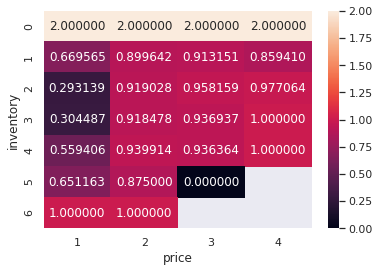

In [116]:
#df = sns.load_dataset("flights")
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#print(table)
ax = sns.heatmap(table, annot=True, fmt="f")


In [111]:
#Begin of the day: t = 5
time_spot = 49
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  price_spot.append(X[i+5001][time_spot])
  inventory_spot.append(all_inventory[i][time_spot])
  action_spot.append(actions[i][time_spot])
price_quartile = []
for i in range(len(price_spot)):
  if price_spot[i] <= np.quantile(price_spot,0.25):
    price_quartile.append(1)
  elif np.quantile(price_spot,0.25) < price_spot[i] <= np.quantile(price_spot,0.5):
    price_quartile.append(2)
  elif np.quantile(price_spot,0.5) < price_spot[i] <= np.quantile(price_spot,0.75):
    price_quartile.append(3)
  elif np.quantile(price_spot,0.75) < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

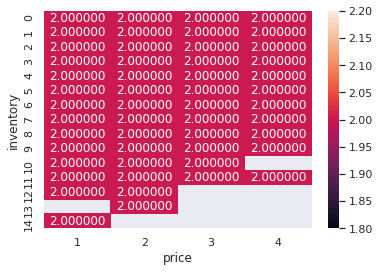

In [114]:
#df = sns.load_dataset("flights")
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#print(table)
ax = sns.heatmap(table, annot=True, fmt="f")


In [119]:
#Begin of the day: t = 5
time_spot = 15
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  price_spot.append(X[i+5001][time_spot])
  inventory_spot.append(all_inventory[i][time_spot])
  action_spot.append(actions[i][time_spot])
price_quartile = []
for i in range(len(price_spot)):
  if price_spot[i] <= np.quantile(price_spot,0.25):
    price_quartile.append(1)
  elif np.quantile(price_spot,0.25) < price_spot[i] <= np.quantile(price_spot,0.5):
    price_quartile.append(2)
  elif np.quantile(price_spot,0.5) < price_spot[i] <= np.quantile(price_spot,0.75):
    price_quartile.append(3)
  elif np.quantile(price_spot,0.75) < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

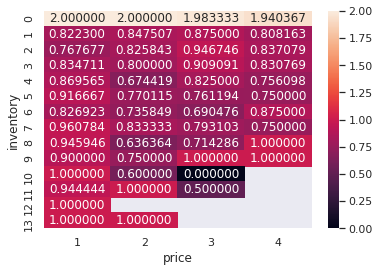

In [120]:
#df = sns.load_dataset("flights")
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#print(table)
ax = sns.heatmap(table, annot=True, fmt="f")


(array([  3.,   3.,   6.,  33.,  65., 102., 212., 316., 523., 717., 574.,
        482., 823., 729., 299.,  78.,  22.,  10.,   1.,   1.]),
 array([-0.08891804, -0.0801941 , -0.07147016, -0.06274623, -0.05402229,
        -0.04529835, -0.03657441, -0.02785047, -0.01912654, -0.0104026 ,
        -0.00167866,  0.00704528,  0.01576921,  0.02449315,  0.03321709,
         0.04194103,  0.05066497,  0.0593889 ,  0.06811284,  0.07683678,
         0.08556072]),
 <a list of 20 Patch objects>)

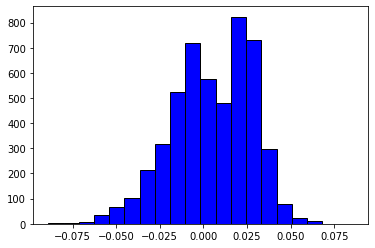

In [52]:
plt.hist(test_profits, color = 'blue', edgecolor = 'black',
         bins = 20)

In [51]:
YEAH = 0
NOOOO = 0
for elem in test_profits:
  if elem >= 0.0:
    YEAH += 1
  else:
    NOOOO -= 1

print("Percentage of Profitting: ", YEAH*100/(len(test_profits)),"%")

Percentage of Profitting:  57.69153830766153 %
